In [ ]:
from fastai2.collab import *
from fastai2.basics import *
from fastai2.callback.all import *

## Collaborative filtering example

`collab` models use data in a `DataFrame` of user, items, and ratings.

In [ ]:
user,item,title = 'userId','movieId','title'

In [ ]:
path = untar_data(URLs.ML_SAMPLE)
path

PosixPath('/home/sgugger/.fastai/data/movie_lens_sample')

In [ ]:
ratings = pd.read_csv(path/'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,73,1097,4.0,1255504951
1,561,924,3.5,1172695223
2,157,260,3.5,1291598691
3,358,1210,5.0,957481884
4,130,316,2.0,1138999234


That's all we need to create and train a model:

In [ ]:
dbunch = CollabDataBunch.from_df(ratings, bs=64, seed=42)

In [ ]:
y_range = [0,5.5]

In [ ]:
learn = collab_learner(dbunch, n_factors=50, y_range=y_range)

In [ ]:
learn.fit_one_cycle(3, 5e-3)

epoch,train_loss,valid_loss,time
0,1.554303,0.831812,00:01
1,0.825112,0.690816,00:01
2,0.647874,0.682837,00:01


## Movielens 100k

Let's try with the full Movielens 100k data dataset, available from http://files.grouplens.org/datasets/movielens/ml-100k.zip

In [ ]:
path=Config().data/'ml-100k'

In [ ]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=[user,item,'rating','timestamp'])
ratings.head()

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [ ]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1', header=None,
                    names=[item, 'title', 'date', 'N', 'url', *[f'g{i}' for i in range(19)]])
movies.head()

,movieId,title,date,N,url,g0,g1,g2,g3,g4,...,g9,g10,g11,g12,g13,g14,g15,g16,g17,g18
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%20(1995),0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(1995),0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%20(1995),0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
len(ratings)

100000

In [ ]:
rating_movie = ratings.merge(movies[[item, title]])
rating_movie.head()

,userId,movieId,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [ ]:
dbunch = CollabDataBunch.from_df(rating_movie, seed=42, valid_pct=0.1, bs=64, item_name=title, path=path)

In [ ]:
dbunch.show_batch()

,userId,title,rating
0,756,"Devil's Own, The (1997)",3
1,328,Dances with Wolves (1990),3
2,21,Booty Call (1997),1
3,119,"Kiss Me, Guido (1997)",4
4,504,Casino (1995),4
5,477,Forget Paris (1995),5
6,936,"Story of Xinghua, The (1993)",5
7,198,"Graduate, The (1967)",4
8,484,Beauty and the Beast (1991),5
9,780,"Godfather: Part II, The (1974)",5


In [ ]:
y_range = [0,5.5]

In [ ]:
learn = collab_learner(dbunch, n_factors=40, y_range=y_range)

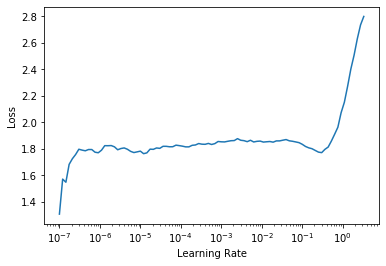

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, 5e-3,  wd=1e-1)

epoch,train_loss,valid_loss,time
0,0.931693,0.941807,00:21
1,0.850625,0.871287,00:22
2,0.756273,0.817352,00:21
3,0.636691,0.801060,00:21
4,0.569860,0.800570,00:21


In [ ]:
learn.save('dotprod')

Here's [some benchmarks](https://www.librec.net/release/v1.3/example.html) on the same dataset for the popular Librec system for collaborative filtering. They show best results based on RMSE of 0.91, which corresponds to an MSE of `0.91**2 = 0.83`.

## Interpretation

### Setup

In [ ]:
learn.load('dotprod');

In [ ]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 40)
  (i_weight): Embedding(1650, 40)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1650, 1)
)

In [ ]:
g = rating_movie.groupby(title)['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)',
       'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)',
       'Air Force One (1997)', 'Independence Day (ID4) (1996)'],
      dtype=object)

### Movie bias

In [ ]:
movie_bias = learn.model.bias(top_movies, is_item=True)
movie_bias.shape

torch.Size([1000])

In [ ]:
mean_ratings = rating_movie.groupby(title)['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies,movie_bias)]

In [ ]:
item0 = lambda o:o[0]

In [ ]:
sorted(movie_ratings, key=item0)[:15]

[(tensor(-0.3289),
  'Lawnmower Man 2: Beyond Cyberspace (1996)',
  1.7142857142857142),
 (tensor(-0.3260),
  'Children of the Corn: The Gathering (1996)',
  1.3157894736842106),
 (tensor(-0.2979), 'Crow: City of Angels, The (1996)', 1.9487179487179487),
 (tensor(-0.2845), 'Mortal Kombat: Annihilation (1997)', 1.9534883720930232),
 (tensor(-0.2573), 'Cable Guy, The (1996)', 2.339622641509434),
 (tensor(-0.2363), 'Beautician and the Beast, The (1997)', 2.313953488372093),
 (tensor(-0.2333), 'Bio-Dome (1996)', 1.903225806451613),
 (tensor(-0.2325), "Joe's Apartment (1996)", 2.2444444444444445),
 (tensor(-0.2321), 'Home Alone 3 (1997)', 1.894736842105263),
 (tensor(-0.2307), 'Showgirls (1995)', 1.9565217391304348),
 (tensor(-0.2307), 'Grease 2 (1982)', 2.0),
 (tensor(-0.2259), 'Leave It to Beaver (1997)', 1.8409090909090908),
 (tensor(-0.2249), 'Barb Wire (1996)', 1.9333333333333333),
 (tensor(-0.2202), 'Free Willy 3: The Rescue (1997)', 1.7407407407407407),
 (tensor(-0.2186), 'Spice Worl

In [ ]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(tensor(0.5933), "Schindler's List (1993)", 4.466442953020135),
 (tensor(0.5851), 'Titanic (1997)', 4.2457142857142856),
 (tensor(0.5805), 'Shawshank Redemption, The (1994)', 4.445229681978798),
 (tensor(0.5645), 'L.A. Confidential (1997)', 4.161616161616162),
 (tensor(0.5407), 'Silence of the Lambs, The (1991)', 4.28974358974359),
 (tensor(0.5339), 'As Good As It Gets (1997)', 4.196428571428571),
 (tensor(0.5291), 'Good Will Hunting (1997)', 4.262626262626263),
 (tensor(0.5266), 'Star Wars (1977)', 4.3584905660377355),
 (tensor(0.5192), 'Rear Window (1954)', 4.3875598086124405),
 (tensor(0.4909), 'Apt Pupil (1998)', 4.1),
 (tensor(0.4903), 'Close Shave, A (1995)', 4.491071428571429),
 (tensor(0.4831), 'Usual Suspects, The (1995)', 4.385767790262173),
 (tensor(0.4737), 'Wrong Trousers, The (1993)', 4.466101694915254),
 (tensor(0.4721), 'Godfather, The (1972)', 4.283292978208232),
 (tensor(0.4678), 'Casablanca (1942)', 4.45679012345679)]

### Movie weights

In [ ]:
movie_w = learn.model.weight(top_movies, is_item=True)
movie_w.shape

torch.Size([1000, 40])

In [ ]:
movie_pca = movie_w.pca(3)
movie_pca.shape

torch.Size([1000, 3])

In [ ]:
fac0,fac1,fac2 = movie_pca.t()
movie_comp = [(f, i) for f,i in zip(fac0, top_movies)]

In [ ]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.2022), 'Chinatown (1974)'),
 (tensor(1.0636), 'Casablanca (1942)'),
 (tensor(1.0587), 'Close Shave, A (1995)'),
 (tensor(1.0058), 'When We Were Kings (1996)'),
 (tensor(1.0037),
  'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)'),
 (tensor(1.0000), 'Secrets & Lies (1996)'),
 (tensor(0.9804), '12 Angry Men (1957)'),
 (tensor(0.9794), 'Wrong Trousers, The (1993)'),
 (tensor(0.9636), 'Third Man, The (1949)'),
 (tensor(0.9589), 'Citizen Kane (1941)')]

In [ ]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.1824), 'Jungle2Jungle (1997)'),
 (tensor(-1.1321), 'Bio-Dome (1996)'),
 (tensor(-1.1158), 'Congo (1995)'),
 (tensor(-1.1141), 'Children of the Corn: The Gathering (1996)'),
 (tensor(-1.1061), 'Home Alone 3 (1997)'),
 (tensor(-1.1023), 'Free Willy 3: The Rescue (1997)'),
 (tensor(-1.0989), "McHale's Navy (1997)"),
 (tensor(-1.0858), 'Leave It to Beaver (1997)'),
 (tensor(-1.0330), 'Mortal Kombat: Annihilation (1997)'),
 (tensor(-1.0300), 'Batman & Robin (1997)')]

In [ ]:
movie_comp = [(f, i) for f,i in zip(fac1, top_movies)]

In [ ]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(0.9087), 'Brazil (1985)'),
 (tensor(0.8986), 'Trainspotting (1996)'),
 (tensor(0.8424), 'Clockwork Orange, A (1971)'),
 (tensor(0.8214), 'Lost Highway (1997)'),
 (tensor(0.8024), 'Ready to Wear (Pret-A-Porter) (1994)'),
 (tensor(0.7901), 'Very Brady Sequel, A (1996)'),
 (tensor(0.7850), 'Jude (1996)'),
 (tensor(0.7704), 'Cable Guy, The (1996)'),
 (tensor(0.7703), 'Serial Mom (1994)'),
 (tensor(0.7600), 'Boogie Nights (1997)')]

In [ ]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.1782), 'Braveheart (1995)'),
 (tensor(-1.1390), 'Raiders of the Lost Ark (1981)'),
 (tensor(-1.0768), 'Titanic (1997)'),
 (tensor(-0.9345), "It's a Wonderful Life (1946)"),
 (tensor(-0.9156), 'Forrest Gump (1994)'),
 (tensor(-0.9069), 'American President, The (1995)'),
 (tensor(-0.8672), 'Independence Day (ID4) (1996)'),
 (tensor(-0.8466), 'Field of Dreams (1989)'),
 (tensor(-0.8392), "Mr. Holland's Opus (1995)"),
 (tensor(-0.8043), 'Pretty Woman (1990)')]

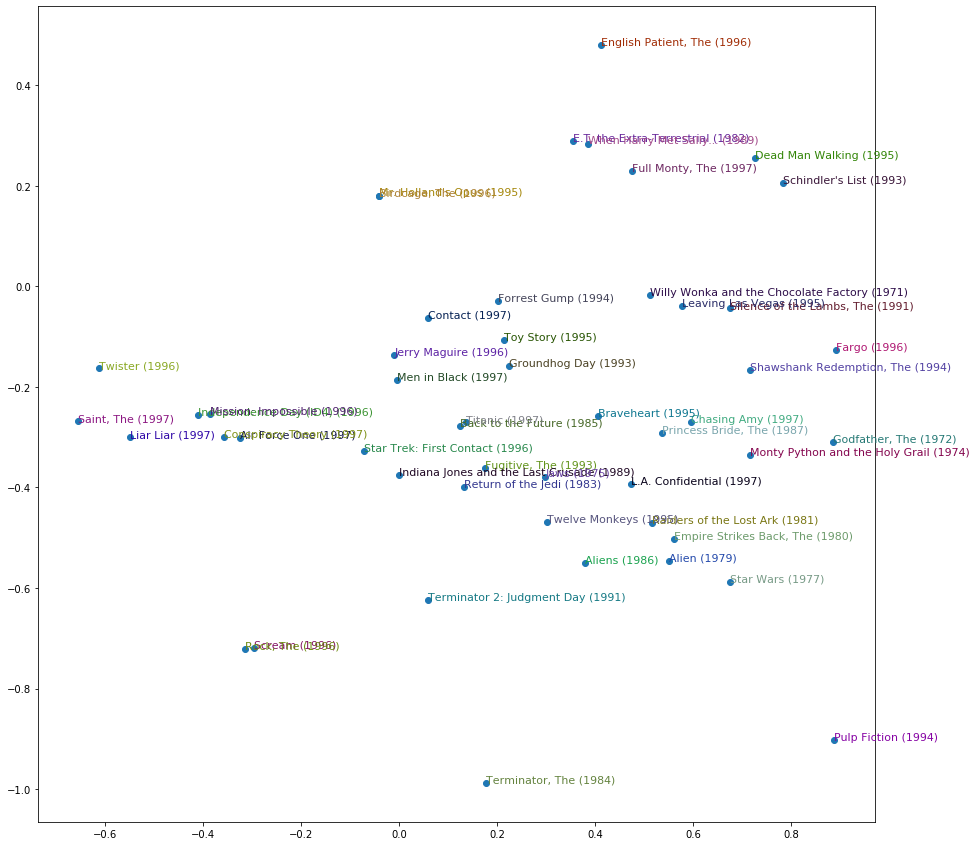

In [ ]:
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()